This example goes through fiber photometry analysis using techniques 
such as data smoothing, bleach detrending, and z-score analysis. 
The epoch averaging was done using TDTfilter.

Author Contributions: 
TDT, David Root, and the Morales Lab contributed to the writing and/or conceptualization of the code. 
The signal processing pipeline was inspired by the workflow developed by David Barker et al. (2017) for the Morales Lab. 
The data used in the example were provided by David Root.

Author Information: 
David H. Root 
Assistant Professor 
Department of Psychology & Neuroscience 
University of Colorado, Boulder 
Lab Website: https://www.root-lab.org 
david.root@colorado.edu

About the authors: 
The Root lab and Morales lab investigate the neurobiology of reward, aversion, addiction, and depression.

TDT edits all user submissions in coordination with the contributing
author(s) prior to publishing.

# Front Matter

In [1]:
# magic for Jupyter
%matplotlib inline

#import the read_block function from the tdt package
#also import other python packages we care about
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt  # standard Python plotting library
import scipy.stats as stats

from tdt import read_block, epoc_filter, download_demo_data

#%% Importing the Data
download_demo_data()
BLOCKPATH = 'data/FiPho-180416'
data = read_block(BLOCKPATH)

demo data ready
read from t=0s to t=583.86s


In [2]:
# Jupyter has a bug that requires import of matplotlib outside of cell with 
# matplotlib inline magic to properly apply rcParams
import matplotlib 
matplotlib.rcParams['font.size'] = 16 #set font size for all plots

# Setup the variables for the data you want to extract
We will extract two different stream stores surrounding the 'PtAB' epoch event. We are interested in a specific event code for the shock onset.

In [3]:
REF_EPOC = 'PtAB' #event store name. This holds behavioral codes that are 
# read through ports A & B on the front of the RZ
SHOCK_CODE = [64959] #shock onset event code we are interested in

# make some variables up here to so if they change in new recordings you won't
# have to change everything downstream
ISOS = '_4054' # 405nm channel. Formally STREAM_STORE1 in maltab example
GCaMP = '_4654' # 465nm channel. Formally STREAM_STORE2 in maltab example
TRANGE = [-10, 20] # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-10, -6] # baseline period within our window
ARTIFACT = float("inf") # optionally set an artifact rejection level

#call read block - new variable 'data' is the full data structure
data = read_block(BLOCKPATH)

read from t=0s to t=583.86s


# Use epoc_filter to extract data around our epoc event
Using the 't' parameter extracts data only from the time range around our epoc event. Use the 'values' parameter to specify allowed values of the REF_EPOC to extract.  For stream events, the chunks of data are stored in cell arrays structured as data.streams[GCaMP].filtered

In [4]:
data = epoc_filter(data, REF_EPOC, t=TRANGE, values=SHOCK_CODE)

In [5]:
# Optionally remove artifacts. If any waveform is above ARTIFACT level, or
# below -ARTIFACT level, remove it from the data set.
total1 = np.size(data.streams[GCaMP].filtered)
total2 = np.size(data.streams[ISOS].filtered)

# List comprehension checking if any single array in 2D filtered array is > Artifact or < -Artifact
data.streams[GCaMP].filtered = [x for x in data.streams[GCaMP].filtered 
                                if not np.any(x > ARTIFACT) or np.any(x < -ARTIFACT)]
data.streams[ISOS].filtered = [x for x in data.streams[ISOS].filtered 
                               if not np.any(x > ARTIFACT) or np.any(x < -ARTIFACT)]

# Get the total number of rejected arrays
bad1 = total1 - np.size(data.streams[GCaMP].filtered)
bad2 = total2 - np.size(data.streams[ISOS].filtered)
total_artifacts = bad1 + bad2

Applying a time filter to a uniformly sampled signal means that the length of each segment could vary by one sample. Let's find the minimum length so we can trim the excess off before calculating the mean.

In [6]:
# More examples of list comprehensions
min1 = np.min([np.size(x) for x in data.streams[GCaMP].filtered])
min2 = np.min([np.size(x) for x in data.streams[ISOS].filtered])
data.streams[GCaMP].filtered = [x[1:min1] for x in data.streams[GCaMP].filtered]
data.streams[ISOS].filtered = [x[1:min2] for x in data.streams[ISOS].filtered]

# Downsample and average 10x via a moving window mean
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []
for lst in data.streams[ISOS].filtered: 
    small_lst = []
    for i in range(0, min2, N):
        small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
    F405.append(small_lst)

for lst in data.streams[GCaMP].filtered: 
    small_lst = []
    for i in range(0, min1, N):
        small_lst.append(np.mean(lst[i:i+N-1]))
    F465.append(small_lst)

#Create a mean signal, standard error of signal, and DC offset
meanF405 = np.mean(F405, axis=0)
stdF405 = np.std(F405, axis=0)/np.sqrt(len(data.streams[ISOS].filtered))
dcF405 = np.mean(meanF405)
meanF465 = np.mean(F465, axis=0)
stdF465 = np.std(F465, axis=0)/np.sqrt(len(data.streams[GCaMP].filtered))
dcF465 = np.mean(meanF465)

# Plot epoc averaged response

In [7]:
# Create the time vector for each stream store
ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data.streams[GCaMP].fs*N
ts2 = TRANGE[0] + np.linspace(1, len(meanF405), len(meanF405))/data.streams[ISOS].fs*N

# Subtract DC offset to get signals on top of one another
meanF405 = meanF405 - dcF405
meanF465 = meanF465 - dcF465

# Start making a figure with 4 subplots
# First plot is the 405 and 465 averaged signals
fig = plt.figure(figsize=(9, 14))
ax0 = fig.add_subplot(411) # work with axes and not current plot (plt.)

# Plotting the traces
p1, = ax0.plot(ts1, meanF465, linewidth=2, color='green', label='GCaMP')
p2, = ax0.plot(ts2, meanF405, linewidth=2, color='blueviolet', label='ISOS')

# Plotting standard error bands
p3 = ax0.fill_between(ts1, meanF465+stdF465, meanF465-stdF465,
                      facecolor='green', alpha=0.2)
p4 = ax0.fill_between(ts2, meanF405+stdF405, meanF405-stdF405,
                      facecolor='blueviolet', alpha=0.2)

# Plotting a line at t = 0
p5 = ax0.axvline(x=0, linewidth=3, color='slategray', label='Shock Onset')

# Finish up the plot
ax0.set_xlabel('Seconds')
ax0.set_ylabel('mV')
ax0.set_title('Foot Shock Response, %i Trials (%i Artifacts Removed)'
              % (len(data.streams[GCaMP].filtered), total_artifacts))
ax0.legend(handles=[p1, p2, p5], loc='upper right')
ax0.set_ylim(min(np.min(meanF465-stdF465), np.min(meanF405-stdF405)),
             max(np.max(meanF465+stdF465), np.max(meanF405+stdF405)))
ax0.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0]);

plt.close() # Jupyter cells will output any figure calls made, so if you don't want to see it just yet, close existing axis
            # https://stackoverflow.com/questions/18717877/prevent-plot-from-showing-in-jupyter-notebook
            # Note that this is not good code practice - Jupyter lends it self to these types of bad workarounds 

# Fitting 405 channel onto 465 channel to detrend signal bleaching
Scale and fit data. Algorithm sourced from Tom Davidson's Github:
https://github.com/tjd2002/tjd-shared-code/blob/master/matlab/photometry/FP_normalize.m


In [8]:
Y_fit_all = []
Y_dF_all = []
for x, y in zip(F405, F465):
    x = np.array(x)
    y = np.array(y)
    bls = np.polyfit(x, y, 1)
    fit_line = np.multiply(bls[0], x) + bls[1]
    Y_fit_all.append(fit_line)
    Y_dF_all.append(y-fit_line)

# Getting the z-score and standard error
zall = []
for dF in Y_dF_all: 
   ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
   zb = np.mean(dF[ind])
   zsd = np.std(dF[ind])
   zall.append((dF - zb)/zsd)
   
zerror = np.std(zall, axis=0)/np.sqrt(np.size(zall, axis=0))

# Heat Map based on z score of 405 fit subtracted 465

In [9]:
ax1 = fig.add_subplot(412)
cs = ax1.imshow(zall, cmap=plt.cm.Greys, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(data.streams[GCaMP].filtered)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Individual z-Score Traces')
ax1.set_ylabel('Trials')
ax1.set_xlabel('Seconds from Shock Onset')

plt.close() # Suppress figure output again

# Plot the z-score trace for the 465 with std error bands

In [10]:
ax2 = fig.add_subplot(413)
p6 = ax2.plot(ts2, np.mean(zall, axis=0), linewidth=2, color='green', label='GCaMP')
p7 = ax2.fill_between(ts1, np.mean(zall, axis=0)+zerror
                      ,np.mean(zall, axis=0)-zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label='Shock Onset')
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('Foot Shock Response')

plt.close()

# Quantify changes as an area under the curve for cue (-5 sec) vs shock (0 sec)

In [11]:
AUC = [] # cue, shock
ind1 = np.where((np.array(ts2)<-3) & (np.array(ts2)>-5))
AUC1= auc(ts2[ind1], np.mean(zall, axis=0)[ind1])
ind2 = np.where((np.array(ts2)>0) & (np.array(ts2)<2))
AUC2= auc(ts2[ind2], np.mean(zall, axis=0)[ind2])
AUC.append(AUC1)
AUC.append(AUC2)

# Run a two-sample T-test
t_stat,p_val = stats.ttest_ind(np.mean(zall, axis=0)[ind1],
                               np.mean(zall, axis=0)[ind2], equal_var=False)

# Make a bar plot

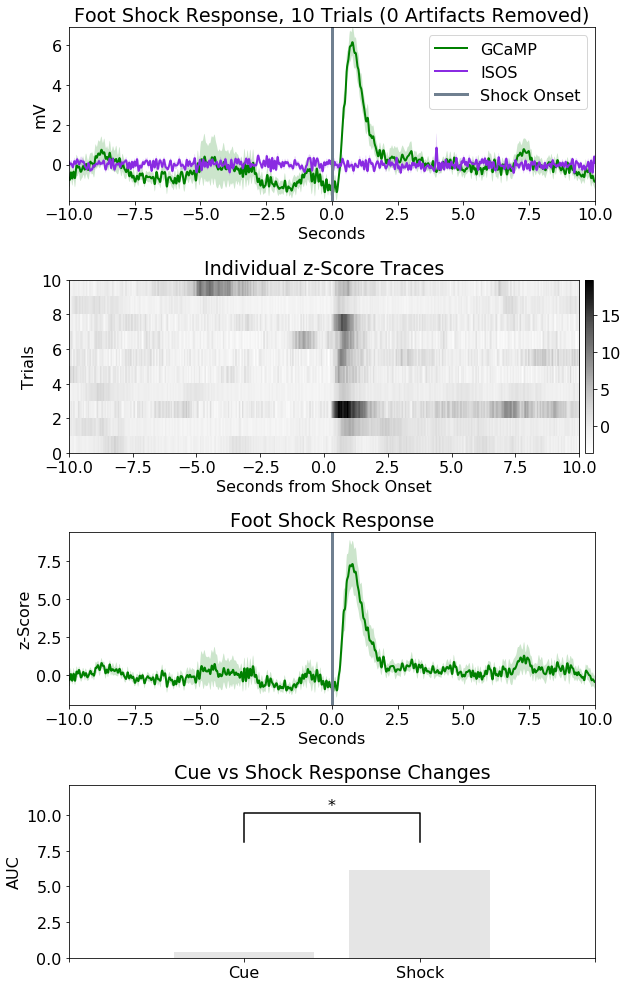

In [12]:
ax3 = fig.add_subplot(414)
p9 = ax3.bar(np.arange(len(AUC)), AUC, color=[.8, .8, .8], align='center', alpha=0.5)

# statistical annotation
x1, x2 = 0, 1 # columns indices for labels
y, h, col = max(AUC) + 2, 2, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
p10 = ax3.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# Finish up the plot
ax3.set_ylim(0,y+2*h)
ax3.set_ylabel('AUC')
ax3.set_title('Cue vs Shock Response Changes')
ax3.set_xticks(np.arange(-1, len(AUC)+1))
ax3.set_xticklabels(['','Cue','Shock',''])

fig.tight_layout()
fig